This notebook implements the main LSTM-FCN model used for supervised fault classification on the Tennessee Eastman Process (TEP) dataset. All configurations are evaluated on the same normalized train/validation/test splits using an identical training and evaluation pipeline to ensure fair comparison.

## Module Versions used:

In [11]:
import sys
libraries = {
    'python': sys.version.split()[0],
    'numpy': __import__('numpy').__version__,
    'pandas': __import__('pandas').__version__,
    'torch': __import__('torch').__version__,
    'tensorflow': __import__('tensorflow').__version__,
    'scikit-learn': __import__('sklearn').__version__,
}

for lib, version in libraries.items():
    print(f"{lib} == {version}")

python == 3.11.7
numpy == 2.0.2
pandas == 2.2.3
torch == 2.5.1+cpu
tensorflow == 2.18.0
scikit-learn == 1.6.1


In [12]:
import os
import numpy as np
import tensorflow as tf
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
import matplotlib.pyplot as plt

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [13]:
train = pd.read_csv(r'C:\Users\pagar\OneDrive\Desktop\prof kitchin\Tennessee Eastman\latest csvs\supervised_train_new.csv')
test = pd.read_csv(r'C:\Users\pagar\OneDrive\Desktop\prof kitchin\Tennessee Eastman\latest csvs\supervised_test_new.csv')
val = pd.read_csv(r'C:\Users\pagar\OneDrive\Desktop\prof kitchin\Tennessee Eastman\latest csvs\supervised_val_new.csv')

In [14]:
import random
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
import numpy as np

# def seed_everything(seed=42):
#     """
#     Ensures reproducibility across Python, NumPy, and PyTorch.
#     """
#     random.seed(seed)
#     np.random.seed(seed)
#     torch.manual_seed(seed)
#     torch.cuda.manual_seed_all(seed)

#     # deterministic results (slower but reproducible)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# seed_everything(42)
# g = torch.Generator().manual_seed(42)

# -------------------------------------------------------
# Feature selection + scaling
# -------------------------------------------------------
# Use all xmeas/xmv as features
features = [col for col in train.columns if 'xmeas' in col or 'xmv' in col]
target   = 'faultNumber'

train_df_c = train.copy()
val_df_c   = val.copy()
test_df_c  = test.copy()

scaler = StandardScaler()
train_df_c[features] = scaler.fit_transform(train_df_c[features])
val_df_c[features]   = scaler.transform(val_df_c[features])
test_df_c[features]  = scaler.transform(test_df_c[features])

# -------------------------------------------------------
# SequenceDataset (sliding window per trajectory)
# -------------------------------------------------------
class SequenceDataset(Dataset):
    def __init__(self, df, features, target, seq_len=30, label_map=None, run_col="traj_key"):
        self.X = []
        self.y = []
        self.seq_len  = seq_len
        self.features = features
        self.target   = target
        self.label_map = label_map
        self.run_col   = run_col

        # sort by trajectory + time
        df = df.sort_values([run_col, "sample"]).reset_index(drop=True)

        for run_id, g in df.groupby(run_col):
            g = g.reset_index(drop=True)
            if len(g) < seq_len:
                continue

            # len(g) - seq_len + 1 windows per trajectory
            for i in range(len(g) - seq_len + 1):
                seq   = g.iloc[i:i+seq_len][features].values
                label = g.iloc[i+seq_len - 1][target]

                if self.label_map is not None:
                    label = self.label_map[label]

                self.X.append(seq)
                self.y.append(label)

        self.X = np.array(self.X)
        self.y = np.array(self.y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx], dtype=torch.float32),
            torch.tensor(self.y[idx], dtype=torch.long)
        )

# -------------------------------------------------------
# Build label mapping, excluding specific faults
# -------------------------------------------------------
def extract_all_labels(df, target, seq_len=30):
    return [int(df.iloc[i+seq_len - 1][target]) for i in range(len(df) - seq_len)]

seq_len = 30

y_train_raw = extract_all_labels(train_df_c, target, seq_len=seq_len)
y_val_raw   = extract_all_labels(val_df_c,   target, seq_len=seq_len)
y_test_raw  = extract_all_labels(test_df_c,  target, seq_len=seq_len)

faults_to_exclude = [3, 9, 15]

unique_labels = sorted(set(y_train_raw) | set(y_val_raw) | set(y_test_raw))
unique_labels = [label for label in unique_labels if label not in faults_to_exclude]

label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
index_to_label = {idx: label for label, idx in label_to_index.items()}
num_classes    = len(label_to_index)

print("Unique labels (after exclusion):", unique_labels)
print("Label → index:", label_to_index)

# -------------------------------------------------------
# Build train / val / test sequence datasets
#   NOTE: change run_col="traj_key" if your run column is named differently
# -------------------------------------------------------
train_dataset = SequenceDataset(
    train_df_c, features, target,
    seq_len=seq_len, label_map=label_to_index, run_col="traj_key"
)
val_dataset = SequenceDataset(
    val_df_c, features, target,
    seq_len=seq_len, label_map=label_to_index, run_col="traj_key"
)
test_dataset = SequenceDataset(
    test_df_c, features, target,
    seq_len=seq_len, label_map=label_to_index, run_col="traj_key"
)

# -------------------------------------------------------
# Convert to NumPy arrays for Keras
# -------------------------------------------------------
X_train_sequences = train_dataset.X.astype("float32")
y_train_sequences = train_dataset.y.astype("int32")

X_val_sequences   = val_dataset.X.astype("float32")
y_val_sequences   = val_dataset.y.astype("int32")

X_test_sequences  = test_dataset.X.astype("float32")
y_test_sequences  = test_dataset.y.astype("int32")

print("Train sequences:", X_train_sequences.shape, "Labels:", y_train_sequences.shape)
print("Val   sequences:", X_val_sequences.shape,   "Labels:", y_val_sequences.shape)
print("Test  sequences:", X_test_sequences.shape,  "Labels:", y_test_sequences.shape)
print("Train label indices (unique):", np.unique(y_train_sequences))


Unique labels (after exclusion): [0, 1, 2, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 16, 17, 18, 19, 20]
Label → index: {0: 0, 1: 1, 2: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 10: 8, 11: 9, 12: 10, 13: 11, 14: 12, 16: 13, 17: 14, 18: 15, 19: 16, 20: 17}
Train sequences: (304060, 30, 52) Labels: (304060,)
Val   sequences: (152030, 30, 52) Labels: (152030,)
Test  sequences: (420045, 30, 52) Labels: (420045,)
Train label indices (unique): [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17]


In [15]:
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Dropout, Conv1D, BatchNormalization, Activation
from tensorflow.keras.layers import GlobalAveragePooling1D, Dense, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import SpatialDropout1D

def generate_lstmfcn(seq_len: int, num_features: int, num_classes: int, num_cells: int, dropout: float):
    ip = Input(shape=(seq_len, num_features))              # (B, L, F)

    # LSTM branch
    x = LSTM(num_cells)(ip)
    x = Dropout(dropout, seed=42)(x)
    x = Dropout(dropout)(x)

    # FCN branch
    y = Conv1D(32, 7, padding='same', kernel_initializer='he_uniform')(ip)
    y = BatchNormalization()(y); y = Activation('relu')(y)
    y = SpatialDropout1D(0.3)(y)

    y = Conv1D(24, 5, padding='same', dilation_rate=2, kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y); y = Activation('relu')(y)

    y = Conv1D(16, 3, padding='same', dilation_rate=4, kernel_initializer='he_uniform')(y)
    y = BatchNormalization()(y); y = Activation('relu')(y)

    y = GlobalAveragePooling1D()(y)

    z = Concatenate()([x, y])
    z = Dense(max(32, num_classes*2), activation='relu')(z) #edit
    # z = Dropout(0.5)(z) #edit
    z = Dropout(0.5, seed=42)(z) #edit
    out = Dense(num_classes, activation='softmax')(z)

    model = Model(ip, out, name="LSTM_FCN")
    return model


In [16]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.optimizers import AdamW
from sklearn.utils.class_weight import compute_class_weight

L = X_train_sequences.shape[1]
F = X_train_sequences.shape[2]
NB_CLASS = int(y_train_sequences.max()) + 1

# seed_everything(42)

model = generate_lstmfcn(seq_len=L, num_features=F, num_classes=NB_CLASS, num_cells=24, dropout=0.5)

optimizer = AdamW(
    learning_rate=1e-4,
    weight_decay=1e-5
)

model.compile(
    # optimizer=Adam(learning_rate=1e-3),
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
model.summary()


history = model.fit(
    X_train_sequences, y_train_sequences,
    validation_data=(X_val_sequences, y_val_sequences),
    epochs=40,
    batch_size=64,
    # shuffle=False, 
    verbose=1
)


Model: "LSTM_FCN"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 30, 52)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_3 (Conv1D)   │ (None, 30, 32)    │     11,680 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 32)    │        128 │ conv1d_3[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 30, 32)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spatial_dropout1d_1 │ (None, 30, 32)    │          0 │ activation_3[0][… │
│ (SpatialDropout1D)  │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_4 (Conv1D)   │ (None, 30, 24)    │      3,864 │ spatial_dropout1… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 24)    │         96 │ conv1d_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 30, 24)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_5 (Conv1D)   │ (None, 30, 16)    │      1,168 │ activation_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 24)        │      7,392 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 30, 16)    │         64 │ conv1d_5[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 24)        │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 30, 16)    │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 24)        │          0 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 16)        │          0 │ activation_5[0][… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 40)        │          0 │ dropout_4[0][0],  │
│ (Concatenate)       │                   │            │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 36)        │      1,476 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 36)        │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 18)        │        666 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 26,534 (103.65 KB)

 Trainable params: 26,390 (103.09 KB)

 Non-trainable params: 144 (576.00 B)

Epoch 1/40
4751/4751 ━━━━━━━━━━━━━━━━━━━━ 74s 14ms/step - accuracy: 0.4592 - loss: 1.9966 - val_accuracy: 0.7816 - val_loss: 0.7877
Epoch 2/40
4751/4751 ━━━━━━━━━━━━━━━━━━━━ 64s 14ms/step - accuracy: 0.7382 - loss: 0.9046 - val_accuracy: 0.8661 - val_loss: 0.4472
Epoch 3/40
4751/4751 ━━━━━━━━━━━━━━━━━━━━ 65s 14ms/step - accuracy: 0.8201 - loss: 0.6049 - val_accuracy: 0.9306 - val_loss: 0.2768
Epoch 4/40
4751/4751 ━━━━━━━━━━━━━━━━━━━━ 63s 13ms/step - accuracy: 0.8764 - loss: 0.4290 - val_accuracy: 0.9499 - val_loss: 0.1813
Epoch 5/40
4751/4751 ━━━━━━━━━━━━━━━━━━━━ 81s 13ms/step - accuracy: 0.9078 - loss: 0.3260 - val_accuracy: 0.9561 - val_loss: 0.1490
Epoch 6/40
4751/4751 ━━━━━━━━━━━━━━━━━━━━ 57s 12ms/step - accuracy: 0.9224 - loss: 0.2695 - val_accuracy: 0.9648 - val_loss: 0.1366
Epoch 7/40
4751/4751 ━━━━━━━━━━━━━━━━━━━━ 62s 13ms/step - accuracy: 0.9314 - loss: 0.2374 - val_accuracy: 0.9691 - val_loss: 0.1334
Epoch 8/40
4751/4751 ━━━━━━━━━━━━━━━━━━━━ 77s 12ms/step - accuracy: 0.9376 -

In [17]:
from sklearn.metrics import f1_score, classification_report, accuracy_score
import numpy as np

# Get predictions on test and train sets
y_test_pred_probs = model.predict(X_test_sequences)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)

y_train_pred_probs = model.predict(X_train_sequences)
y_train_pred = np.argmax(y_train_pred_probs, axis=1)

f1 = f1_score(y_test_sequences, y_test_pred, average='weighted')

test_acc = accuracy_score(y_test_sequences, y_test_pred)
train_acc = accuracy_score(y_train_sequences, y_train_pred)

print(f"Test Accuracy: {test_acc:.5f}")
print(f"Train Accuracy: {train_acc:.5f}")
print(f"F1 Score: {f1:.5f}")

print("\nClassification Report:\n")
print(classification_report(y_test_sequences, y_test_pred, digits=5))


13127/13127 ━━━━━━━━━━━━━━━━━━━━ 25s 2ms/step
9502/9502 ━━━━━━━━━━━━━━━━━━━━ 20s 2ms/step
Test Accuracy: 0.99142
Train Accuracy: 0.99397
F1 Score: 0.99132

Classification Report:

              precision    recall  f1-score   support

           0    0.99254   0.99973   0.99612    223440
           1    0.99279   1.00000   0.99638     11565
           2    0.99931   1.00000   0.99965     11565
           3    0.99041   1.00000   0.99518     11565
           4    0.99672   1.00000   0.99836     11565
           5    1.00000   1.00000   1.00000     11565
           6    1.00000   1.00000   1.00000     11565
           7    0.97487   0.98297   0.97890     11565
           8    0.99806   0.97717   0.98750     11565
           9    1.00000   0.98911   0.99452     11565
          10    0.99901   0.87004   0.93007     11565
          11    0.95850   0.98063   0.96944     11565
          12    1.00000   1.00000   1.00000     11565
          13    0.99129   0.98392   0.98759     11565
         

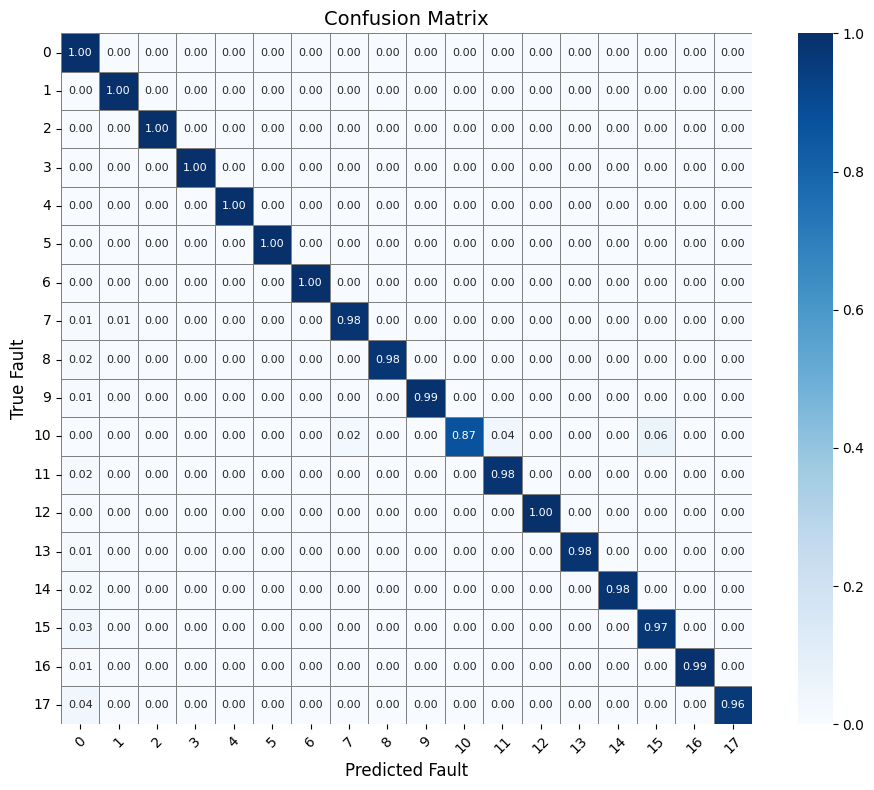

In [18]:
# Confusion matrix (separate step)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix

# Use predictions produced earlier in the notebook
try:
    y_true = np.asarray(y_test_sequences).reshape(-1)
    y_pred = np.asarray(y_test_pred).reshape(-1)
except NameError:
    raise NameError("y_test_sequences and/or y_test_pred are not defined. Run the prediction cell first.")

# Determine display labels (original fault numbers) if label_encoder is available
if 'label_encoder' in globals():
    display_labels = label_encoder.classes_
else:
    display_labels = np.unique(y_true)

# Number of classes
if 'NB_CLASS' in globals():
    n_classes = NB_CLASS
else:
    n_classes = int(max(y_true.max(), y_pred.max()) + 1)

# Compute confusion matrix and normalize per true class
cm = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
with np.errstate(divide='ignore', invalid='ignore'):
    cm_norm = cm.astype(float) / (cm.sum(axis=1)[:, None] + 1e-12)
    cm_norm = np.nan_to_num(cm_norm)

# Plot confusion matrix alone
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=display_labels, yticklabels=display_labels,
            cbar=True, square=True, linewidths=0.5, linecolor="gray",
            annot_kws={"size":8}, ax=ax)
ax.set_xlabel("Predicted Fault", fontsize=12)
ax.set_ylabel("True Fault", fontsize=12)
ax.set_title("Confusion Matrix", fontsize=14)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

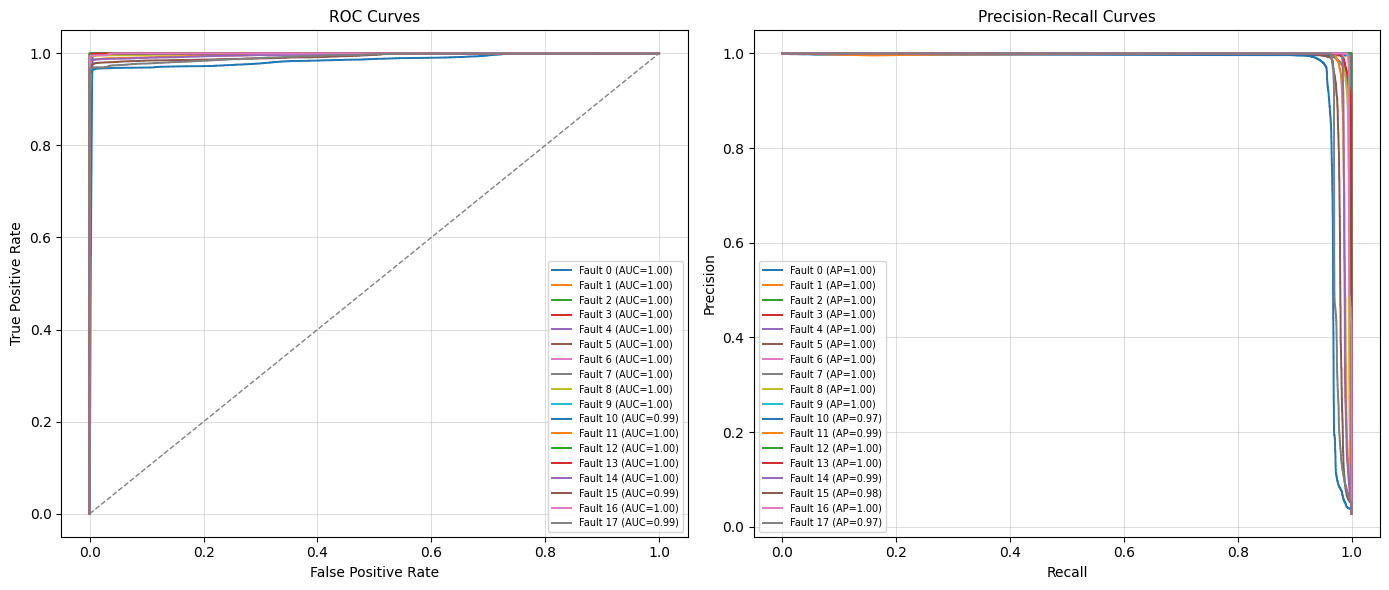

In [19]:
# ROC and Precision-Recall curves (separate step)
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.preprocessing import label_binarize
import numpy as np

# Ensure required variables exist
try:
    y_true = np.asarray(y_test_sequences).reshape(-1)
    y_pred_prob = np.asarray(y_test_pred_probs)
except NameError:
    raise NameError("y_test_sequences and/or y_test_pred_probs not found. Run the prediction cell first.")

# Determine display labels
if 'label_encoder' in globals():
    display_labels = label_encoder.classes_
else:
    display_labels = np.unique(y_true)

# Determine number of classes
if 'NB_CLASS' in globals():
    n_classes = NB_CLASS
else:
    n_classes = int(np.unique(y_true).shape[0])

# Binarize true labels for ROC/PR
y_true_bin = label_binarize(y_true, classes=np.arange(n_classes))

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# ROC curves
ax = axes[0]
for i in range(y_true_bin.shape[1]):
    try:
        fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_prob[:, i])
        roc_auc = auc(fpr, tpr)
        ax.plot(fpr, tpr, linewidth=1.4, label=f"Fault {display_labels[i]} (AUC={roc_auc:.2f})")
    except Exception:
        continue
ax.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=1)
ax.set_xlabel('False Positive Rate', fontsize=10)
ax.set_ylabel('True Positive Rate', fontsize=10)
ax.set_title('ROC Curves', fontsize=11)
ax.grid(alpha=0.4)
ax.legend(fontsize=7, loc='lower right')

# Precision-Recall curves
ax = axes[1]
for i in range(y_true_bin.shape[1]):
    try:
        precision, recall, _ = precision_recall_curve(y_true_bin[:, i], y_pred_prob[:, i])
        ap = average_precision_score(y_true_bin[:, i], y_pred_prob[:, i])
        ax.plot(recall, precision, linewidth=1.4, label=f"Fault {display_labels[i]} (AP={ap:.2f})")
    except Exception:
        continue
ax.set_xlabel('Recall', fontsize=10)
ax.set_ylabel('Precision', fontsize=10)
ax.set_title('Precision-Recall Curves', fontsize=11)
ax.grid(alpha=0.4)
ax.legend(fontsize=7, loc='lower left')

plt.tight_layout()
plt.show()

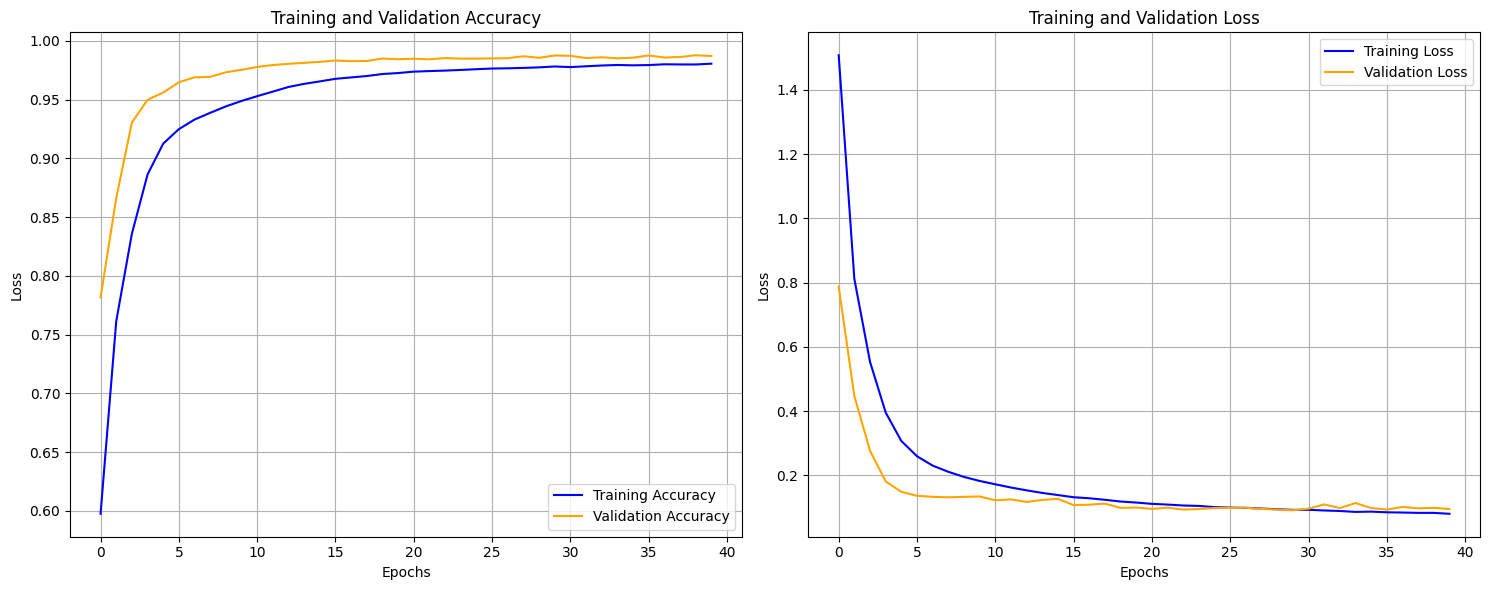

In [20]:
import matplotlib.pyplot as plt

# Assuming 'history' is the object returned by model.fit()
# Extract training and validation loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']   

# Plotting the loss curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
# plt.figure(figsize=(10, 6))
ax2.plot(train_loss, label='Training Loss', color='blue')
ax2.plot(val_loss, label='Validation Loss', color='orange')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Loss')
ax2.set_title('Training and Validation Loss')
ax2.legend()
ax2.grid(True)

ax1.plot(train_acc, label='Training Accuracy', color='blue')
ax1.plot(val_acc, label='Validation Accuracy', color='orange')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Accuracy')
ax1.legend()
ax1.grid(True)
plt.tight_layout()
plt.show()
